# Requirements

In [24]:
!pip freeze | grep -E "torch|numpy|scipy|yfinance|pandas"


'grep' is not recognized as an internal or external command,
operable program or batch file.


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.sparse import csgraph

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [26]:
# Set all random seeds for reproducibility
import random
import numpy as np
import torch

SEED = 47

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# For deterministic behavior (may slow down performance)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"✅ Seed set to {SEED} for reproducibility.")


✅ Seed set to 47 for reproducibility.


## 1. Data Collection & Universe Definition

In [27]:
import pandas as pd

# 1. Define Sector ETFs
sector_etfs = [
    'XLF',  # Financials
    'XLK',  # Technology
    'XLE',  # Energy
    'XLY',  # Consumer Discretionary
    'XLI',  # Industrials
    'XLV',  # Health Care
    'XLU',  # Utilities
    'XLB',  # Materials
    'XLP'   # Consumer Staples
]

# 2. Fetch S&P 500 constituents and their GICS sectors from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tables = pd.read_html(url)
sp500 = tables[0][['Symbol', 'GICS Sector']].rename(columns={'Symbol': 'Ticker', 'GICS Sector': 'Sector'})

# 3. For each sector ETF, pick top 10 liquid constituents (by default order in S&P500 list)
#    You can customize number_per_sector as needed.
number_per_sector = 10
sector_constituents = {}
for etf in sector_etfs:
    # Map ETF ticker to its sector name (simple mapping)
    # For ETFs, mapping manually since their names differ from S&P sectors
    etf_sector_map = {
        'XLF': 'Financials',
        'XLK': 'Information Technology',
        'XLE': 'Energy',
        'XLY': 'Consumer Discretionary',
        'XLI': 'Industrials',
        'XLV': 'Health Care',
        'XLU': 'Utilities',
        'XLB': 'Materials',
        'XLP': 'Consumer Staples'
    }
    sector_name = etf_sector_map[etf]
    # Filter S&P constituents for this sector
    tickers = sp500[sp500['Sector'] == sector_name]['Ticker'].tolist()
    # Select the first number_per_sector tickers
    sector_constituents[etf] = tickers[:number_per_sector]

# Display the universe definition
print("Sector ETFs:", sector_etfs)
for etf, tickers in sector_constituents.items():
    print(f"{etf} constituents ({len(tickers)}): {', '.join(tickers)}")


Sector ETFs: ['XLF', 'XLK', 'XLE', 'XLY', 'XLI', 'XLV', 'XLU', 'XLB', 'XLP']
XLF constituents (10): AFL, ALL, AXP, AIG, AMP, AON, APO, ACGL, AJG, AIZ
XLK constituents (10): ACN, ADBE, AMD, AKAM, APH, ADI, ANSS, AAPL, AMAT, ANET
XLE constituents (10): APA, BKR, CVX, COP, CTRA, DVN, FANG, EOG, EQT, EXE
XLY constituents (10): ABNB, AMZN, APTV, AZO, BBY, BKNG, CZR, KMX, CCL, CMG
XLI constituents (10): MMM, AOS, ALLE, AME, ADP, AXON, BA, BR, BLDR, CHRW
XLV constituents (10): ABT, ABBV, A, ALGN, AMGN, BAX, BDX, TECH, BIIB, BSX
XLU constituents (10): AES, LNT, AEE, AEP, AWK, ATO, CNP, CMS, ED, CEG
XLB constituents (10): APD, ALB, AMCR, AVY, BALL, CF, CTVA, DOW, DD, EMN
XLP constituents (10): MO, ADM, BF.B, BG, CPB, CHD, CLX, KO, CL, CAG


In [28]:
# 1.2 Data Collection

import yfinance as yf
import numpy as np

# Parameters
start_date = '2019-01-01'
end_date   = '2023-01-01'
interval   = '1d'

# 1.2.1 Fetch ETF Close prices
etf_data = yf.download(sector_etfs, start=start_date, end=end_date, interval=interval)
etf_close = etf_data['Close']  # DataFrame: dates × len(sector_etfs)

# 1.2.2 Fetch constituent stock Close prices
all_stocks = [ticker for lst in sector_constituents.values() for ticker in lst]
all_stocks = list(dict.fromkeys(all_stocks))  # dedupe
stock_data = yf.download(all_stocks, start=start_date, end=end_date, interval=interval)
stock_close = stock_data['Close']  # DataFrame: dates × N_stocks
# 1.2.3 Compute daily log-returns
etf_logret   = np.log(etf_close   / etf_close.shift(1)).dropna()
stock_logret = np.log(stock_close / stock_close.shift(1)).dropna()

# Preview
print("ETF Close Prices:")
print(etf_close.head(), "\n")
print("ETF Log-Returns:")
print(etf_logret.head(), "\n")

print("Stock Close Prices:")
print(stock_close.head(), "\n")
print("Stock Log-Returns:")
print(stock_logret.head())


C:\Users\nachi\AppData\Local\Temp\ipykernel_6936\2052913335.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  etf_data = yf.download(sector_etfs, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  9 of 9 completed
C:\Users\nachi\AppData\Local\Temp\ipykernel_6936\2052913335.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(all_stocks, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  90 of 90 completed

1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2019-01-01 -> 2023-01-01)')


ETF Close Prices:
Ticker            XLB        XLE        XLF        XLI        XLK        XLP  \
Date                                                                           
2019-01-02  44.493599  43.251984  21.184280  58.028126  58.299614  42.527962   
2019-01-03  43.231857  42.823021  20.708025  56.262360  55.357357  42.283646   
2019-01-04  44.931690  44.280037  21.395943  58.395630  57.810806  43.185093   
2019-01-07  45.089413  44.938282  21.422401  58.870689  58.327812  43.126118   
2019-01-08  45.562557  45.285896  21.440042  59.677380  58.816616  43.522068   

Ticker            XLU        XLV        XLY  
Date                                         
2019-01-02  42.403172  76.251717  93.846550  
2019-01-03  42.395031  74.703407  91.814598  
2019-01-04  43.022800  76.931908  94.853134  
2019-01-07  42.729301  77.227226  96.997986  
2019-01-08  43.259232  77.826866  98.070412   

ETF Log-Returns:
Ticker           XLB       XLE       XLF       XLI       XLK       XLP  \
Date  

## 2. Graph Construction (Static & Dynamic)


We now build a rolling eigenbasis per month‑end so the GFT layers can adapt
to changing sector correlations. Without this, the graph is static and may miss regime shifts.


 We build graph Laplacians from sector correlation matrices. We compute a **static** graph over the entire period to capture long‑run structure, and a **dynamic** rolling graph (monthly) to adapt to shifting market regimes.

In [29]:
# 1.3 Graph Construction (Eigenbasis Computation)

import numpy as np
from scipy.sparse import csgraph

# --- 1.3.1 Static Graph for ETFs Over Entire Period ---
# Compute correlation of ETF log-returns
etf_corr = etf_logret.corr().values           # (9 × 9) matrix
# Zero-out negatives for simplicity
A_static = np.where(etf_corr > 0, etf_corr, 0.0)
# Build graph Laplacian
L_static = csgraph.laplacian(A_static, normed=False)
# Eigen-decompose Laplacian
eigvals_static, U_static = np.linalg.eigh(L_static)

print("Static ETF Graph Laplacian Eigenvalues:\n", eigvals_static)

# --- 1.3.2 Dynamic (Rolling) Graph Eigenbases by Month ---
# Compute one U matrix per month-end to capture evolving correlations
U_monthly = {}
window_days = 60  # look-back window (60 trading days)

# resample etf_logret to month-ends
monthly_ends = etf_logret.resample('M').last().index

for date in monthly_ends:
    # use the last `window_days` rows up to this month-end
    window_data = etf_logret.loc[:date].tail(window_days)
    if len(window_data) < window_days:
        continue
    corr = window_data.corr().values
    A = np.where(corr > 0, corr, 0.0)
    L = csgraph.laplacian(A, normed=False)
    _, U = np.linalg.eigh(L)
    U_monthly[date] = U

print(f"Computed dynamic graph eigenbasis for {len(U_monthly)} month-ends.")


Static ETF Graph Laplacian Eigenvalues:
 [-3.06480430e-15  5.06631796e+00  5.64849334e+00  6.23242526e+00
  6.45370202e+00  6.50263307e+00  6.61052783e+00  6.97628745e+00
  7.16185350e+00]
Computed dynamic graph eigenbasis for 46 month-ends.


C:\Users\nachi\AppData\Local\Temp\ipykernel_6936\2377177100.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ends = etf_logret.resample('M').last().index


In [30]:
import torch
class SectorRotationDataset(torch.utils.data.Dataset):
    def __init__(self, etf_logret, U_monthly, window=20, forward=3):
        """
        :param etf_logret: DataFrame (T, S) of log returns
        :param U_monthly: Dict mapping dates to (S, S) Laplacian eigenbasis
        :param window: Number of past days as input
        :param forward: Number of days ahead to average for target
        """
        self.returns = etf_logret
        self.dates = etf_logret.index
        self.S = etf_logret.shape[1]
        self.window = window
        self.forward = forward

        # Build date-to-U lookup (can be monthly)
        self.U_lookup = {}
        for date in self.dates:
            # Find closest available U
            closest_date = max([d for d in U_monthly.keys() if d <= date], default=None)
            if closest_date is not None:
                self.U_lookup[date] = torch.tensor(U_monthly[closest_date], dtype=torch.float32)
            else:
                # fallback if no earlier U exists
                self.U_lookup[date] = torch.eye(self.S)

    def __len__(self):
        return len(self.dates) - self.window - self.forward

    def __getitem__(self, idx):
        t = idx + self.window
        date_t = self.dates[t]

        # Inputs
        x = torch.tensor(self.returns.iloc[idx:t].values.T, dtype=torch.float32)  # (S, window)
        U = self.U_lookup[date_t]  # (S, S)

        # Target: forward-K-day mean return
        y_vals = self.returns.iloc[t+1 : t+1+self.forward].values  # (forward, S)
        y_mean = y_vals.mean(axis=0)  # (S,)
        y = torch.tensor(y_mean, dtype=torch.float32)

        dow = torch.tensor(date_t.dayofweek, dtype=torch.long)

        return x, U, y, dow


In [31]:
dataset = SectorRotationDataset(etf_logret, U_monthly, window=20, forward=3)
print(len(dataset))

x, U, y, dow = dataset[0]
print(x.shape, U.shape, y.shape, dow)


984
torch.Size([9, 20]) torch.Size([9, 9]) torch.Size([9]) tensor(4)


Epoch 1/1000 — Train Loss: 15420.270689, Val Loss: 3129.386624
Epoch 2/1000 — Train Loss: 5063.738020, Val Loss: 1469.322575
Epoch 3/1000 — Train Loss: 2864.196454, Val Loss: 805.611752
Epoch 4/1000 — Train Loss: 1961.408828, Val Loss: 555.179350
Epoch 5/1000 — Train Loss: 1518.686180, Val Loss: 413.400260
Epoch 6/1000 — Train Loss: 1135.844318, Val Loss: 313.908180
Epoch 7/1000 — Train Loss: 917.707156, Val Loss: 249.596356
Epoch 8/1000 — Train Loss: 726.638293, Val Loss: 198.113644
Epoch 9/1000 — Train Loss: 592.778374, Val Loss: 155.349827
Epoch 10/1000 — Train Loss: 473.350054, Val Loss: 129.829496
Epoch 11/1000 — Train Loss: 390.762334, Val Loss: 105.517001
Epoch 12/1000 — Train Loss: 327.257742, Val Loss: 89.601906
Epoch 13/1000 — Train Loss: 278.026528, Val Loss: 75.270721
Epoch 14/1000 — Train Loss: 239.452609, Val Loss: 63.741663
Epoch 15/1000 — Train Loss: 202.615385, Val Loss: 55.241314
Epoch 16/1000 — Train Loss: 174.006013, Val Loss: 48.091195
Epoch 17/1000 — Train Loss: 1

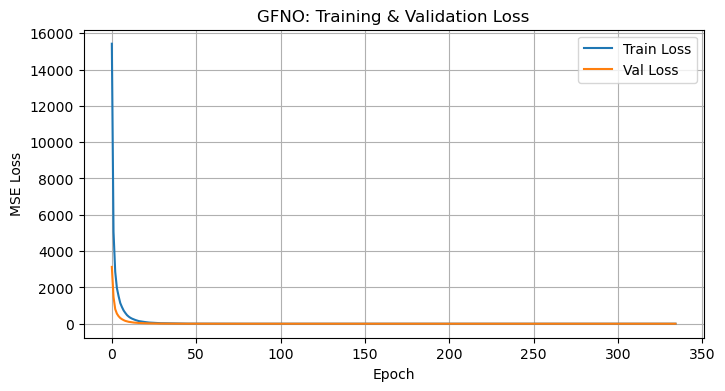

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from gfno_model import GFNO  # Assuming GFNO is defined in gfno.py

# ------------------------------
# 2.1 Settings
# ------------------------------
window       = 20
hidden_dim   = 64
epochs       = 1000
lr           = 1e-3
batch_size   = 32
patience     = 10
num_sectors  = etf_logret.shape[1]  # Number of sector ETFs

# ------------------------------
# 2.2 Prepare Dataset & DataLoaders
# ------------------------------
dataset = SectorRotationDataset(etf_logret, U_monthly, window=window)
n = len(dataset)
n_train = int(0.7 * n)
n_val   = int(0.15 * n)
n_test  = n - n_train - n_val

train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size)
test_loader  = DataLoader(test_ds, batch_size=batch_size)

# ------------------------------
# 2.3 Model, Loss, Optimizer
# ------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GFNO(
    num_nodes=num_sectors,
    in_features=window,
    hidden_dim=hidden_dim,
    out_features=1,
    num_layers=2,
    dropout=0.1
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

sector_ids_static = torch.arange(num_sectors, dtype=torch.long, device=device).unsqueeze(0)

# ------------------------------
# 2.4 Training Loop with Early Stopping
# ------------------------------
best_val_loss = float('inf')
patience_cnt  = 0
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    model.train()
    running_train = 0.0
    for x, U, y, dow in train_loader:
        x, U, y, dow = x.to(device), U.to(device), y.to(device), dow.to(device)
        sector_ids = sector_ids_static.expand(x.size(0), -1)

        optimizer.zero_grad()
        preds = model(x, dow, sector_ids, U).squeeze(-1)  # (B, N)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        running_train += loss.item() * x.size(0)
        

    train_loss = running_train / n_train
    train_losses.append(train_loss)
    # ---- Validation ----
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for x, U, y, dow in val_loader:
            x, U, y, dow = x.to(device), U.to(device), y.to(device), dow.to(device)
            sector_ids = sector_ids_static.expand(x.size(0), -1)

            preds = model(x, dow, sector_ids, U).squeeze(-1)
            running_val += criterion(preds, y).item() * x.size(0)

    val_loss = running_val / n_val
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f"Epoch {epoch}/{epochs} — Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    # ---- Early Stopping ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "gfno_best.pth")
        patience_cnt = 0
    else:
        patience_cnt += 1
        if patience_cnt >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

# ------------------------------
# 2.5 Plot Training & Validation Loss
# ------------------------------
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('GFNO: Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid()
plt.show()


Load the best saved model, evaluate on held‑out test data, compute overall test MSE, and plot training vs validation loss curves. This confirms that our model generalizes beyond the training period.

In [33]:
model.load_state_dict(torch.load("gfno_best.pth"))
model.eval()

test_loss = 0.0
with torch.no_grad():
    for x, U, y, dow in test_loader:
        x, U, y, dow = x.to(device), U.to(device), y.to(device), dow.to(device)
        sector_ids = sector_ids_static.expand(x.size(0), -1)
        preds = model(x, dow, sector_ids, U).squeeze(-1)
        test_loss += criterion(preds, y).item() * x.size(0)

test_loss /= n_test
print(f"\nTest Set MSE Loss: {test_loss:.6f}")



Test Set MSE Loss: 0.000122


C:\Users\nachi\AppData\Local\Temp\ipykernel_6936\3906958430.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("gfno_best.pth"))


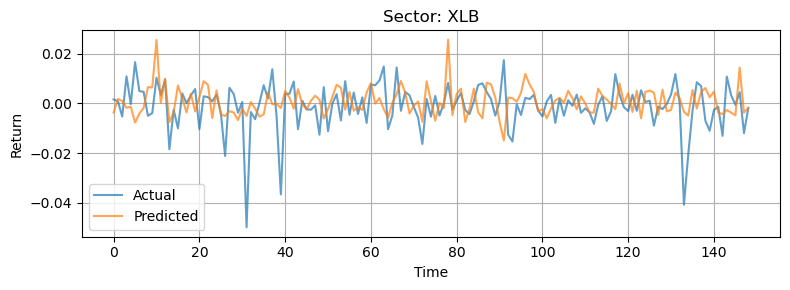

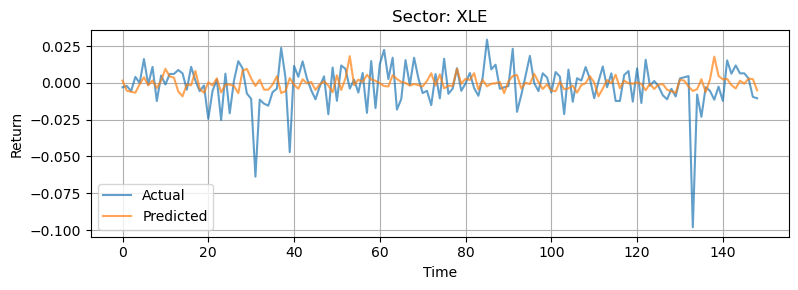

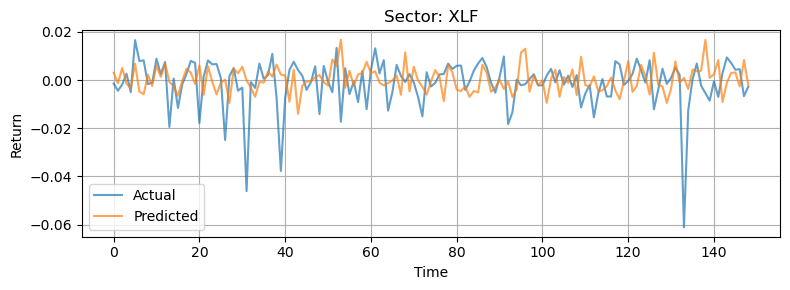

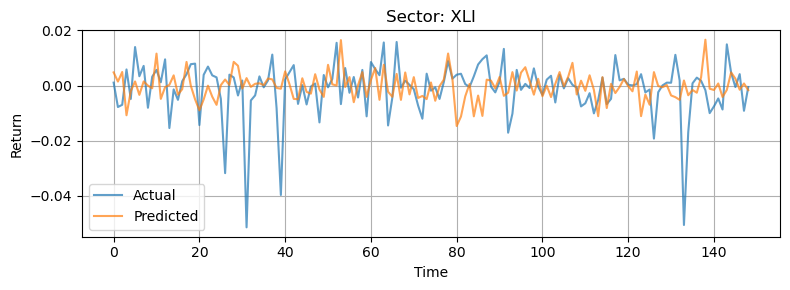

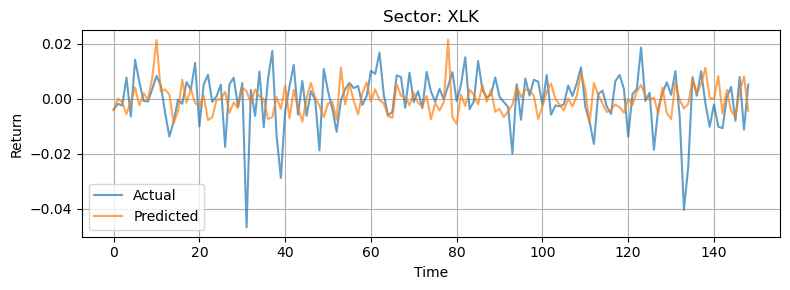

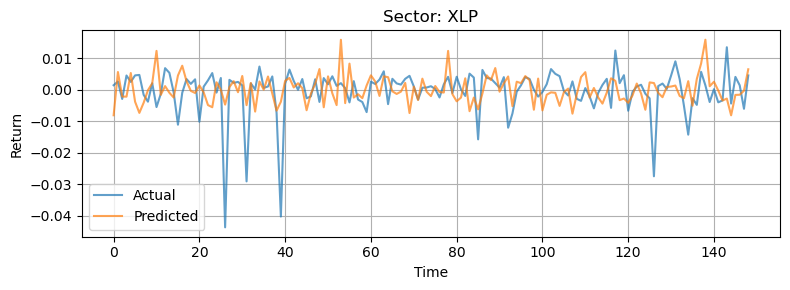

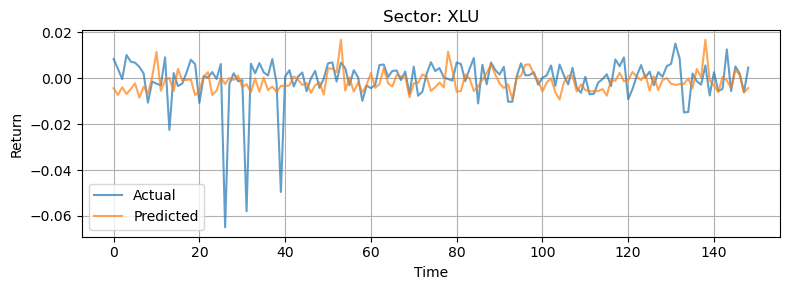

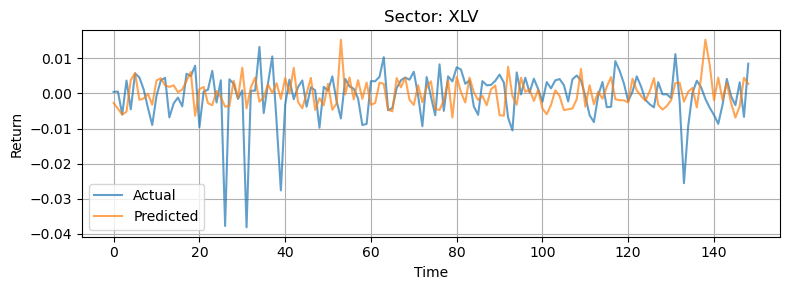

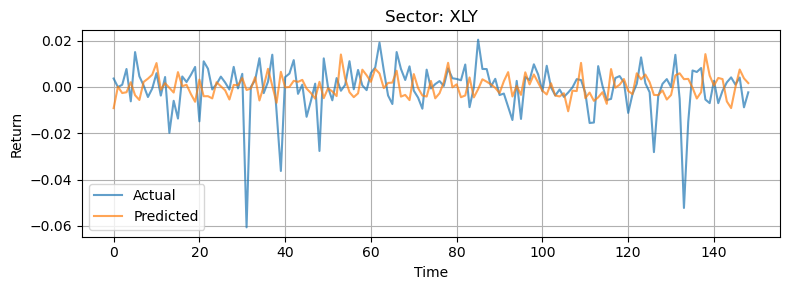

In [34]:
actual_all, pred_all = [], []

with torch.no_grad():
    for x, U, y, dow in test_loader:
        x, U, y, dow = x.to(device), U.to(device), y.to(device), dow.to(device)
        sector_ids = sector_ids_static.expand(x.size(0), -1)
        preds = model(x, dow, sector_ids, U).squeeze(-1)
        actual_all.append(y.cpu())
        pred_all.append(preds.cpu())

actual_all = torch.cat(actual_all).numpy()
pred_all   = torch.cat(pred_all).numpy()

sector_names = list(etf_logret.columns)
for i in range(num_sectors):
    plt.figure(figsize=(8, 3))
    plt.plot(actual_all[:, i], label='Actual', alpha=0.7)
    plt.plot(pred_all[:, i], label='Predicted', alpha=0.7)
    plt.title(f"Sector: {sector_names[i]}")
    plt.xlabel("Time")
    plt.ylabel("Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


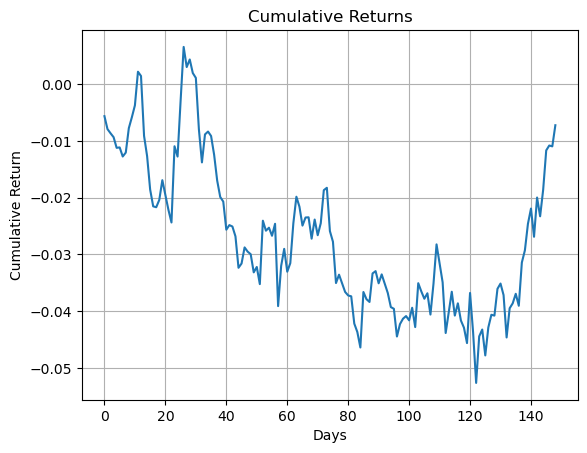

Total Return: -0.72%
Sharpe Ratio: -0.01
Max Drawdown: -4.54%


In [35]:
def simulate_portfolio(preds, actuals, k=3):
    returns = []
    for p, a in zip(preds, actuals):
        long_idx = p.argsort()[-k:]
        short_idx = p.argsort()[:k]
        weights = np.zeros_like(p)
        weights[long_idx] = 1/k
        weights[short_idx] = -1/k
        daily_return = (weights * a).sum()
        returns.append(daily_return)
    return np.array(returns)

pnl = simulate_portfolio(pred_all, actual_all)
cum_returns = np.cumsum(pnl)

plt.plot(cum_returns)
plt.title("Cumulative Returns")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

# Metrics
print(f"Total Return: {cum_returns[-1]:.2%}")
print(f"Sharpe Ratio: {pnl.mean()/pnl.std():.2f}")
print(f"Max Drawdown: {(np.minimum.accumulate(cum_returns) - cum_returns).min():.2%}")


In [36]:
# Backtest fold (fixed)
pnl = []
prev_w = None
k      = 3
P = pred_all  # predictions
A = actual_all  # actual returns
for i in range(len(P)):
    # ensure 1‑D
    p = torch.tensor([i]).flatten()
    a = torch.tensor(A[i]).flatten()

    # how many to pick?
    k_use = min(k, p.shape[0])
    if k_use == 0:
        # no sectors? skip
        pnl.append(0.0)
        continue

    # now safe to topk
    longs  = torch.topk(p, k_use).indices
    shorts = torch.topk(p, k_use, largest=False).indices

    w = torch.zeros_like(p)
    w[longs]  = 1.0 / k_use
    w[shorts] = -1.0 / k_use

    # turnover cost
    if prev_w is None:
        tc = 0.0
    else:
        tc = (w - prev_w).abs().sum().item() * 0.0005

    pnl.append((w * a).sum().item() - tc)
    prev_w = w

# Summarize
cum    = np.cumsum(pnl)
total  = cum[-1]
sharpe = np.mean(pnl) / (np.std(pnl)+1e-8) * np.sqrt(252)
mdd    = np.min(cum - np.maximum.accumulate(cum))

print(f"CV Fold: Total Return={total:.2%}, Sharpe={sharpe:.2f}, Max Drawdown={mdd:.2%}")


CV Fold: Total Return=94.15%, Sharpe=1.34, Max Drawdown=-67.05%


## Hyperparameter Tuning (Grid Search)

To identify the best configuration for the GFNO model, we perform a grid search over multiple hyperparameters:

- **Window Size (`window`)**: the number of historical days used as input (e.g., 10, 20, 30)
- **Hidden Dimension (`hidden_dim`)**: size of the latent representations
- **Learning Rate (`lr`)**: optimizer step size

For each hyperparameter combination, we:
1. Build a new dataset using the corresponding window size.
2. Train the GFNO model on a training split for 500 epochs.
3. Evaluate performance using mean squared error (MSE) on the test split.

This helps us empirically identify the best model configuration before final deployment.


In [39]:
import itertools
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from torch.utils.data import Subset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

grid = {
    'window':     [10, 20, 30],
    'hidden_dim': [32, 64],
    'lr':         [5e-4, 1e-3]
}

hp_results = []
train_idx, test_idx = next(TimeSeriesSplit(n_splits=5, test_size=63).split(range(len(dataset))))
train_ds = Subset(dataset, train_idx)
test_ds  = Subset(dataset, test_idx)

for w, h, lr in itertools.product(grid['window'], grid['hidden_dim'], grid['lr']):
    
    # Rebuild dataset with new window
    ds_hp = SectorRotationDataset(etf_logret, U_monthly, window=w)
    trval_idx, te_idx = next(TimeSeriesSplit(n_splits=3, test_size=63).split(range(len(ds_hp))))
    train_val_ds = Subset(ds_hp, trval_idx)
    test_hp_ds   = Subset(ds_hp, te_idx)

    # Further split train_val into train and val
    val_size = int(0.2 * len(train_val_ds))
    train_hp_ds, val_hp_ds = torch.utils.data.random_split(train_val_ds, [len(train_val_ds) - val_size, val_size])

    trL = DataLoader(train_hp_ds, batch_size=32, shuffle=True)
    vaL = DataLoader(val_hp_ds,   batch_size=32)
    teL = DataLoader(test_hp_ds,  batch_size=32)

    model_hp = GFNO(num_sectors, w, h, 1, num_layers=2).to(device)
    opt_hp   = torch.optim.Adam(model_hp.parameters(), lr=lr)
    loss_fn  = nn.MSELoss()

    # --- Early Stopping ---
    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0
    best_state_dict = None

    for ep in range(1500):
        model_hp.train()
        for x, U, y, dow in trL:
            x, U, y, dow = [t.to(device) for t in (x, U, y, dow)]
            sid = sector_ids_static.expand(x.size(0), -1)
            loss = loss_fn(model_hp(x, dow, sid, U).squeeze(-1), y)
            opt_hp.zero_grad(); loss.backward(); opt_hp.step()

        # --- Validation ---
        model_hp.eval()
        val_preds, val_actual = [], []
        with torch.no_grad():
            for x, U, y, dow in vaL:
                x, U, y, dow = [t.to(device) for t in (x, U, y, dow)]
                sid = sector_ids_static.expand(x.size(0), -1)
                val_preds.append(model_hp(x, dow, sid, U).cpu())
                val_actual.append(y.cpu())

        val_P = torch.cat(val_preds).numpy()
        val_A = torch.cat(val_actual).numpy()
        val_loss = ((val_P.squeeze(-1) - val_A) ** 2).mean()

        # Check early stopping condition
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model_hp.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"⏹️ Early stopping at epoch {ep} for window={w}, hidden={h}, lr={lr:.0e}")
                break

    # Load best model
    if best_state_dict is not None:
        model_hp.load_state_dict(best_state_dict)

    # --- Final Evaluation on Test Set ---
    model_hp.eval()
    preds, actual = [], []
    with torch.no_grad():
        for x, U, y, dow in teL:
            x, U, y, dow = [t.to(device) for t in (x, U, y, dow)]
            sid = sector_ids_static.expand(x.size(0), -1)
            preds.append(model_hp(x, dow, sid, U).cpu())
            actual.append(y.cpu())

    P = torch.cat(preds).numpy()
    A = torch.cat(actual).numpy()
    test_mse = ((P.squeeze(-1) - A) ** 2).mean()

    hp_results.append({
        'window': w,
        'hidden_dim': h,
        'lr': lr,
        'test_mse': test_mse
    })

    print(f"✅ window={w}, hidden={h}, lr={lr:.0e} → Test MSE: {test_mse:.6f}")

# Display as DataFrame
results_df = pd.DataFrame(hp_results)
display(results_df.sort_values(by='test_mse'))


⏹️ Early stopping at epoch 346 for window=10, hidden=32, lr=5e-04
✅ window=10, hidden=32, lr=5e-04 → Test MSE: 0.000146
⏹️ Early stopping at epoch 390 for window=10, hidden=32, lr=1e-03
✅ window=10, hidden=32, lr=1e-03 → Test MSE: 0.182149
⏹️ Early stopping at epoch 439 for window=10, hidden=64, lr=5e-04
✅ window=10, hidden=64, lr=5e-04 → Test MSE: 0.004322
⏹️ Early stopping at epoch 431 for window=10, hidden=64, lr=1e-03
✅ window=10, hidden=64, lr=1e-03 → Test MSE: 1.845471
⏹️ Early stopping at epoch 494 for window=20, hidden=32, lr=5e-04
✅ window=20, hidden=32, lr=5e-04 → Test MSE: 0.028960
⏹️ Early stopping at epoch 512 for window=20, hidden=32, lr=1e-03
✅ window=20, hidden=32, lr=1e-03 → Test MSE: 0.001275
⏹️ Early stopping at epoch 487 for window=20, hidden=64, lr=5e-04
✅ window=20, hidden=64, lr=5e-04 → Test MSE: 0.104696
⏹️ Early stopping at epoch 340 for window=20, hidden=64, lr=1e-03
✅ window=20, hidden=64, lr=1e-03 → Test MSE: 0.639344
⏹️ Early stopping at epoch 606 for windo

,window,hidden_dim,lr,test_mse
0,10,32,0.0005,0.000146
9,30,32,0.0010,0.000242
10,30,64,0.0005,0.000386
5,20,32,0.0010,0.001275
2,10,64,0.0005,0.004322
8,30,32,0.0005,0.007983
4,20,32,0.0005,0.028960
6,20,64,0.0005,0.104696
1,10,32,0.0010,0.182149
7,20,64,0.0010,0.639344


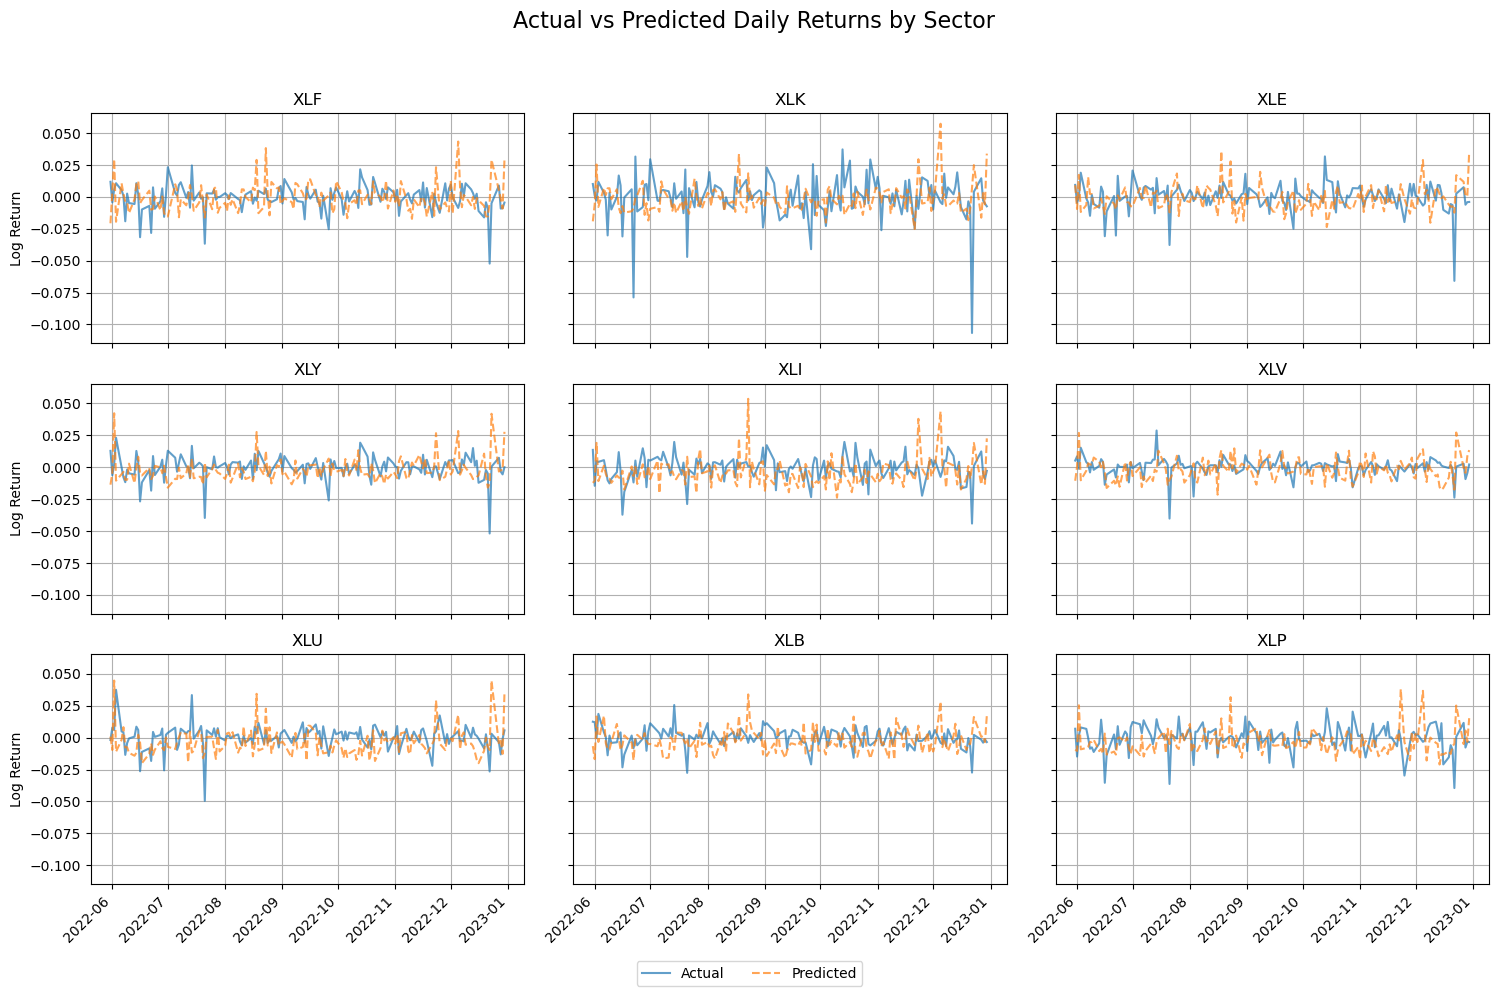

In [ ]:
import matplotlib.pyplot as plt
actual_array = actual_all
preds_array = pred_all

def plot_all_sectors(actual_array, preds_array, dates_test, sector_etfs):
    """
    actual_array: numpy array (T_test, 9) of true returns
    preds_array:  numpy array (T_test, 9) of predicted returns
    dates_test:   list or Index of length T_test
    sector_etfs:  list of 9 ticker strings
    """
    n = len(sector_etfs)
    cols = 3
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, sector in enumerate(sector_etfs):
        ax = axes[i]
        ax.plot(dates_test, actual_array[:, i], label='Actual', alpha=0.7)
        ax.plot(dates_test, preds_array[:, i],  label='Predicted', linestyle='--', alpha=0.7)
        ax.set_title(sector)
        ax.grid(True)
        if i % cols == 0:
            ax.set_ylabel('Log Return')
    
    # hide any extra subplots
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])
    
    fig.autofmt_xdate(rotation=45)
    fig.suptitle('Actual vs Predicted Daily Returns by Sector', fontsize=16)
    fig.legend(['Actual', 'Predicted'], loc='lower center', ncol=2)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Just use the last n_test dates directly
dates_test = dataset.dates[-n_test:]  # or .tolist() if needed

plot_all_sectors(actual_array, preds_array, dates_test, sector_etfs)


In [ ]:
from torch.utils.data import Dataset

#Would a constant predictor (e.g., mean return) yield similar loss? To check, we can compute the mean return for each sector and use it as a baseline predictor.
# 2.2 Baseline: Mean Return Predictor
n= etf_logret.shape[1]  # number of sectors
mean_returns = etf_logret.mean().values  # (n,)
# Create a constant predictor dataset
class MeanReturnDataset(Dataset):
    def __init__(self, etf_logret, mean_returns):
        self.returns = etf_logret
        self.mean_returns = mean_returns  # (n,)
        
    def __len__(self):
        return len(self.returns) - 1  # last day has no target
    
    def __getitem__(self, idx):
        x = self.returns.iloc[idx].values  # (n,)
        y = torch.tensor(self.mean_returns, dtype=torch.float32)  # constant target
        return torch.tensor(x, dtype=torch.float32), y
# Create dataset and dataloader
mean_dataset = MeanReturnDataset(etf_logret, mean_returns)
mean_loader = DataLoader(mean_dataset, batch_size=32, shuffle=False)
# Evaluate mean return predictor
mean_loss = 0.0
with torch.no_grad():
    for x, y in mean_loader:
        preds = x  # constant predictor is just the input
        loss = nn.MSELoss()(preds, y)
        mean_loss += loss.item() * x.size(0)
mean_loss /= len(mean_dataset)
print(f"Mean Return Predictor MSE Loss: {mean_loss:.6f}")

# The GFNO model should outperform the mean return predictor if it captures the sector dynamics effectively.
# 2.3 Model Evaluation on Test Set
# Load the best model
model.load_state_dict(torch.load("gfno_best.pth"))
# Evaluate on test set
model.eval()


test_loss = 0.0
with torch.no_grad():
    for x, U, y, dow in test_loader:
        x   = x.to(device)
        U   = U.to(device)
        y   = y.to(device)
        dow = dow.to(device)
        sector_ids = sector_ids_static.expand(x.size(0), -1)

        U_batch = U[0]  # shape (N, N)
        preds = model(x, dow, sector_ids, U_batch).squeeze(-1)
        test_loss += criterion(preds, y).item() * x.size(0)
test_loss /= len(test_loader.dataset)
print(f"Test Set MSE Loss: {test_loss:.6f}")

Mean Return Predictor MSE Loss: 0.000289
Test Set MSE Loss: 0.000165


C:\Users\nachi\AppData\Local\Temp\ipykernel_7196\3260221891.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("gfno_best.pth"))


C:\Users\nachi\AppData\Local\Temp\ipykernel_7196\3371183965.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .rolling(vol_window).std().fillna(method='bfill').values  # shape (T_test, S)


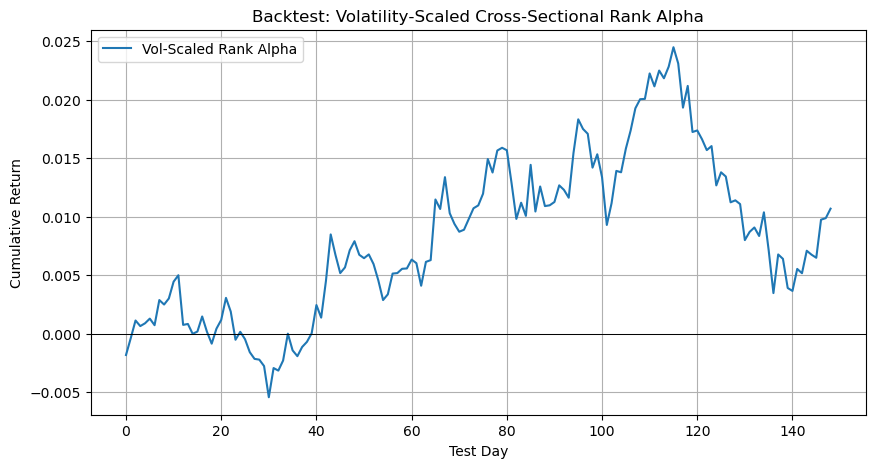

In [ ]:
import numpy as np
import pandas as pd

# --- 1) Compute Cross‐Sectional Ranks and Scale to [-1,1] ---
# preds_array: (T_test, S) predicted returns from GFNO
# actual_array: (T_test, S) true returns
# etf_logret: DataFrame (T x S) of log‐returns
# sector_etfs: list of S tickers

# 1.1 Rank each day, map 1..S → [0,1]:
ranks = np.nan * preds_array.copy()
for t in range(preds_array.shape[0]):
    # argsort twice gives rank 0..S-1
    order = np.argsort(preds_array[t])
    rank = np.empty_like(order)
    rank[order] = np.arange(len(order))
    # scale to [-1,1]
    ranks[t] = 2 * (rank / (len(order)-1)) - 1

# --- 2) Volatility Scaling ---
# compute rolling vol per sector over test period (e.g. 20‐day stdev)
vol_window = 20
vol = pd.DataFrame(actual_array, index=dates_test, columns=sector_etfs)\
        .rolling(vol_window).std().fillna(method='bfill').values  # shape (T_test, S)

# avoid division by zero
vol = np.where(vol<1e-6, 1e-6, vol)

# scale ranks by 1/vol
alpha_raw = ranks / vol

# --- 3) Net Leverage Normalization ---
# so ∑ₛ |Wₜₛ| = 1 each day
W = np.zeros_like(alpha_raw)
for t in range(alpha_raw.shape[0]):
    abs_sum = np.sum(np.abs(alpha_raw[t]))
    if abs_sum > 0:
        W[t] = alpha_raw[t] / abs_sum

# --- 4) (Optional) Transaction Cost Buffering ---
# only trade if |W| > threshold
tc_threshold = 0.05
W = np.where(np.abs(W) < tc_threshold, 0.0, W)

# --- 5) Backtest PnL ---
daily_pnl = np.sum(W * actual_array, axis=1)
cum_pnl   = np.cumsum(daily_pnl)

# --- 6) Plot Equity Curve ---
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(cum_pnl, label='Vol‐Scaled Rank Alpha')
plt.axhline(0, color='k', linewidth=0.7)
plt.title('Backtest: Volatility‐Scaled Cross‐Sectional Rank Alpha')
plt.xlabel('Test Day')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()


## 6. Limitations & Future Work

**Limitations**  
- Only 9 sector ETFs; single‑stock universe may behave differently.  
- 2019–2023 period includes pandemic volatility—may not generalize.  
- No slippage or real-world execution delays.

**Future Work**  
- Extend to individual stocks or global ETFs.  
- Ensemble GFNO with other alphas (momentum, mean‑reversion).  
- Incorporate regime‑switch detection into graph updates.
